# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
#from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib inline
fig_width = 15
dpi = 400
from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [4]:
liste = []
for fname in glob.glob('../data/*pkl'):
    a = fname.split('/')[2].split('.')[0].split('_')
    liste.append(a)

In [5]:
list_sujet = ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10','s11','s12']

nb_sujet = len(list_sujet)
COLOR = [(0+(1/nb_sujet)*n, 0, 0, 0.5) for n in range(nb_sujet)]

In [6]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [7]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

TN YK SR BMC DC CS IP OP FM LB RS AM 

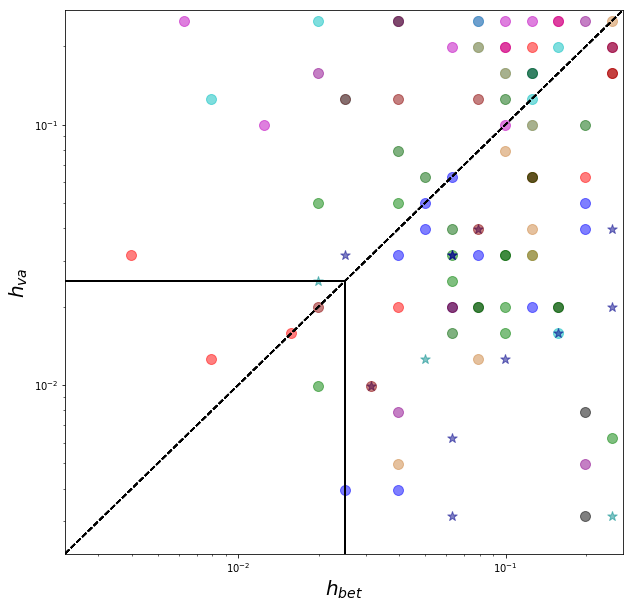

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,10))


Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
list_h = np.geomspace(0.0025, 0.25, 21)

COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan']

for num, s in enumerate(set(Full.sujet)) :
    print(s, end=' ')
    va = Full['va'][Full.sujet==s].values.tolist()
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_va_100, r_bet_100 = [], []
    for c in range(0, 3*200-50, 50) : r_va_100.append([]) ; r_bet_100.append([])

    for h in list_h :

        for d, c in enumerate(range(0, 3*200-50, 50)) :
            x_100 = x[c:c+100]
            p_hat_100 = np.zeros(100)

            liste = [0, 50, 100]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                p_hat_100[liste[a]:liste[a+1]] = p_hat_p
            r_va_100[d].append(r_(p_hat_100.tolist(), va[c:c+100]))
            r_bet_100[d].append(r_(p_hat_100.tolist(), bet[c:c+100]))

    h_va_100, h_bet_100 = [], []
    for d, c in enumerate(range(0, 3*200-50, 50)) :
        h_va_100.append(list_h[np.argmax(r_va_100[d])] if np.argmax(r_va_100[d]) > 0.6 else np.nan)
        h_bet_100.append(list_h[np.argmax(r_bet_100[d])] if np.argmax(r_bet_100[d]) > 0.6 else np.nan)
    ax.scatter(h_va_100, h_bet_100, c=COLOR[num], alpha=0.5, s=100,
               marker='*' if s in ['AM', 'IP'] else None)
    
    ax.plot(np.arange(-10,10), np.arange(-10,10), '--k')
    ax.vlines(0.025, 0, 0.025, colors='k')
    ax.hlines(0.025, 0, 0.025, colors='k')
    
ax.set_xlabel('$h_{bet}$', fontsize=20) ; ax.set_xlim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
ax.set_ylabel('$h_{va}$', fontsize=20)  ; ax.set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
ax.set_xscale("log") ; ax.set_yscale("log")
plt.show()

## Data Scalling

In [7]:
data_scalling = e.Data_Scalling()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
new_bet = data_scalling['new_bet_full']
new_va = data_scalling['new_va_full']

## Find h

In [9]:
h_bet, h_va = e.Find_h(new_bet, new_va)

AM BMC CS DC FM IP LB OP RS SR TN YK 

In [10]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

In [11]:
def regress(ax, p, data, c, minx=0, miny=0, maxx=1, maxy=1, t_label=t_label) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    
    ax.text(maxx-((maxx-minx)/10), miny+((maxy-miny)/10), 'r = %0.3f\np_value = %0.3f'%(r_, p_value), fontsize=t_label/1.2, ha='right', color=c)
    return ax

In [12]:
def scatter_mean(bet, va, titre, maxx=0.55, maxy=0.25, ex=0.02, ey=0.01, log=False, line_r=True, 
                 ellipse=False, triangle=False, color=False, mean='mean', supp=False, fig_width=10) :
    
    if ellipse is True :  from matplotlib.patches import Ellipse
    if triangle is True : from matplotlib.patches import Polygon
    
    
    fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True) #/(1.6180*1))
    
    if type(bet)==dict :
        list_bet, list_va = [], []
        for s in list_sujet : list_bet.append(bet[s]) ; list_va.append(va[s])
        bet, va = list_bet, list_va
    
    m_bet, m_va = [], []
    for x in range(len(bet)):
        if color is False : c = 'k'
        else :              c = color[x]
        
        if ellipse is True :
            ells = Ellipse((np.mean(bet[x]), np.mean(va[x])), 2*np.std(bet[x]), 2*np.std(va[x]), 0,
                           color='k', alpha=0.2, clip_box=axs.bbox)
            axs.add_artist(ells)
        
        elif triangle is True :
            c_b = ['k', 'grey', 'r']
            for b in range(3) : axs.scatter(bet[x][b], va[x][b], c=c_b[b], s=15)
            baba = np.array([[bet[x][y], va[x][y]] for y in range(len(va[x]))])
            poly = Polygon(baba, color=c, alpha=0.2, lw=2)
            axs.add_artist(poly)
            
        if mean=='mean' :      mean_bet, mean_va = np.mean(bet[x]),   np.mean(va[x])
        elif mean=='mediane' : mean_bet, mean_va = np.median(bet[x]), np.median(va[x])           
            
        
        if log is False :
            if triangle is True :
                #axs.scatter(mean_bet, mean_va, color=c,  s=50, alpha=0.9)
                axs.text(mean_bet, mean_va, list_sujet[x], fontsize=12, va='center', ha='center')
            else : axs.errorbar(mean_bet, mean_va, xerr=np.std(bet[x]), yerr=np.std(va[x]),
                                color=c, fmt='o', elinewidth=2, ms=10, alpha=0.6)

        m_bet.append(mean_bet)
        m_va.append(mean_va)

    axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
    axs.vlines(0.025, -ey, 0.025, colors='k')
    axs.hlines(0.025, -ex, 0.025, colors='k')
    

    axs.set_title(titre, fontsize=t_titre)
    axs.set_xlabel('h$_{bet}$', fontsize=t_label)
    axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
    axs.tick_params(axis='both', labelsize=t_label/1.8)
    
    
    if log:
        axs.set_xscale('log')
        axs.set_yscale('log')
        axs.axis([10**-5.5, 10**0, 10**-2.3, 10**0])
    else :
        axs.axis([-ex ,maxx+ex,-ey,maxy+ey])

    if line_r is True :
        regress(axs, m_bet, m_va, 'r', minx=-ex, miny=-ey, maxx=maxx+ex, maxy=(maxy+ey)/2)
        if supp is True :
            for m_ in [m_va, m_bet, m_va,m_bet] : del m_[np.argmax(m_bet)]
            regress(axs, m_bet, m_va, 'k', minx=0, miny=maxy/2, maxx=maxx, maxy=maxy)
    
    fig.tight_layout()
    #plt.show()
    return fig, axs

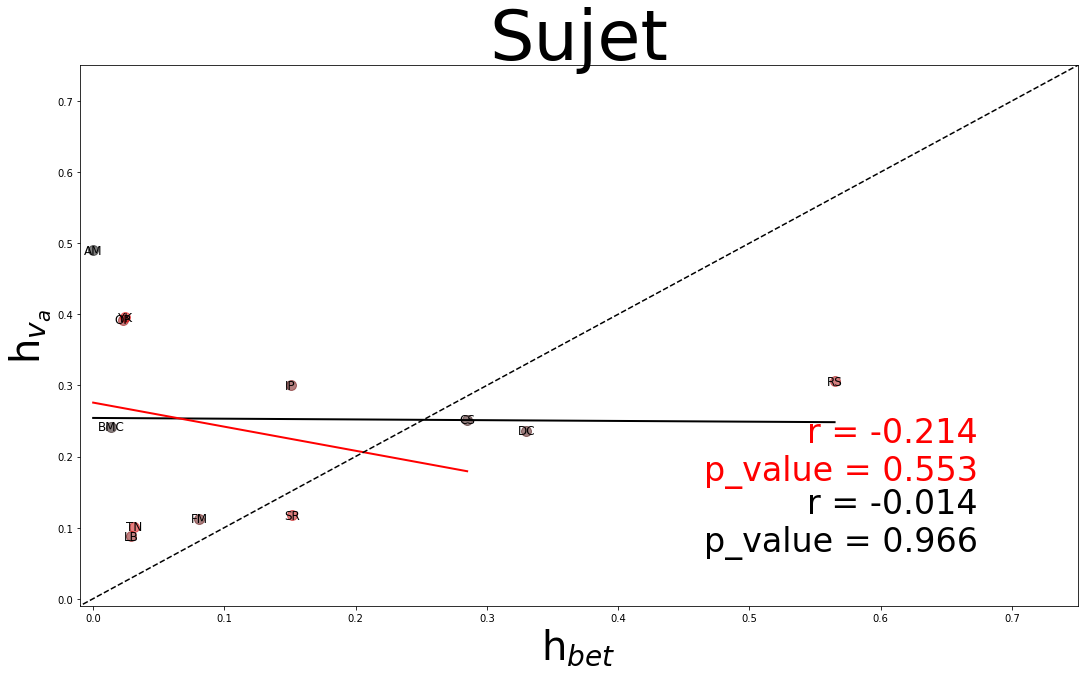

In [13]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

h_bet_sujet, h_va_sujet = [], []
for x, s in enumerate(list_sujet):
    h_bet_sujet.extend(h_bet['sujet'][s])
    h_va_sujet.extend(h_va['sujet'][s])
    axs.scatter(h_bet['sujet'][s], h_va['sujet'][s],color=COLOR[x],s=100)
    axs.text(h_bet['sujet'][s][0], h_va['sujet'][s][0], s, fontsize=12, va='center', ha='center')

axs.set_title('Sujet', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,0.75,-0.01,0.75])

regress(axs, h_bet_sujet, h_va_sujet, 'k', minx=-0.01, miny=-0.01, maxx=0.75, maxy=0.75)

Hva = h_va_sujet.copy()
Hbet = h_bet_sujet.copy()

for H_ in [Hva, Hbet, Hva, Hbet] : del H_[np.argmax(Hbet)]
regress(axs, Hbet, Hva, 'r', minx=-0.01, miny=0.1, maxx=0.75, maxy=0.75)

axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

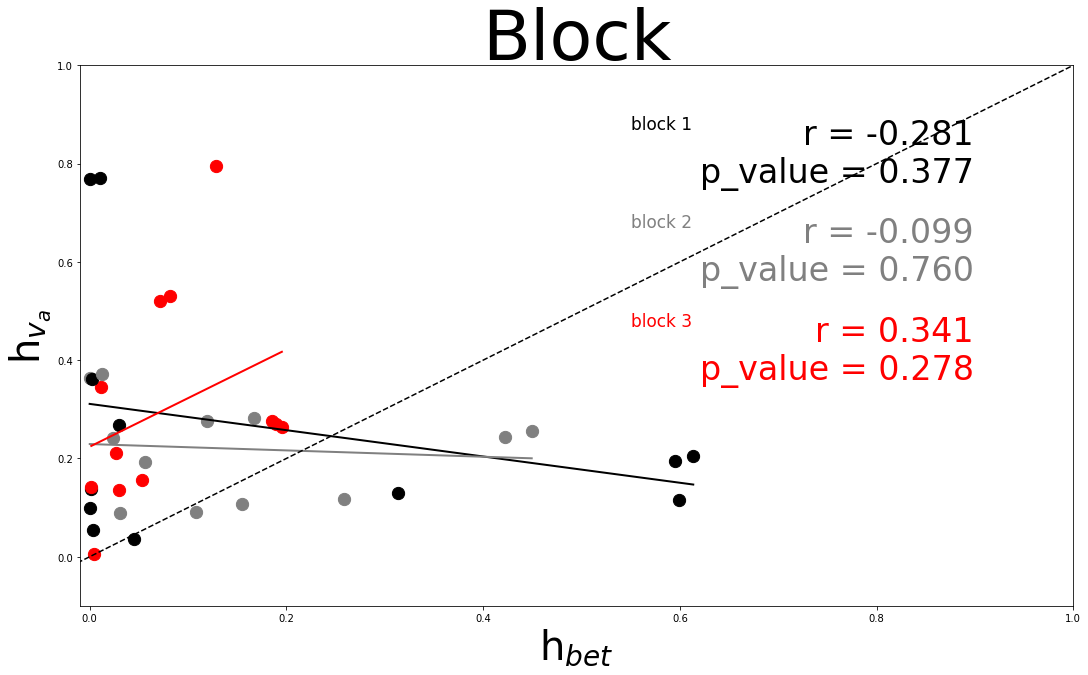

In [14]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

c = ['k', 'grey', 'r']

h_bet_block, h_va_block = [], []
for x, s in enumerate(list_sujet):
    for a in range(len(h_bet['block'][s])) :
        axs.scatter(h_bet['block'][s][a], h_va['block'][s][a],color=c[a], s=150)
        if x==0: h_bet_block.append([]) ; h_va_block.append([])
        h_bet_block[a].append(h_bet['block'][s][a])
        h_va_block[a].append(h_va['block'][s][a])

for a in range(len(h_bet_block)) :
    axs.text(0.55, 0.9-(0.2*(a)+((0.1*(a+3)-0.1*(a))/10)), 'block %s'%(a+1), color=c[a], fontsize=17)
    axs=regress(axs, h_bet_block[a], h_va_block[a], c[a], minx=-0.01, miny=0.8-(0.2*(a)), maxx=1, maxy=1-(0.2*(a+3)))

axs.set_title('Block', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,1,-0.1,1])

axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

Moyenne par block


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


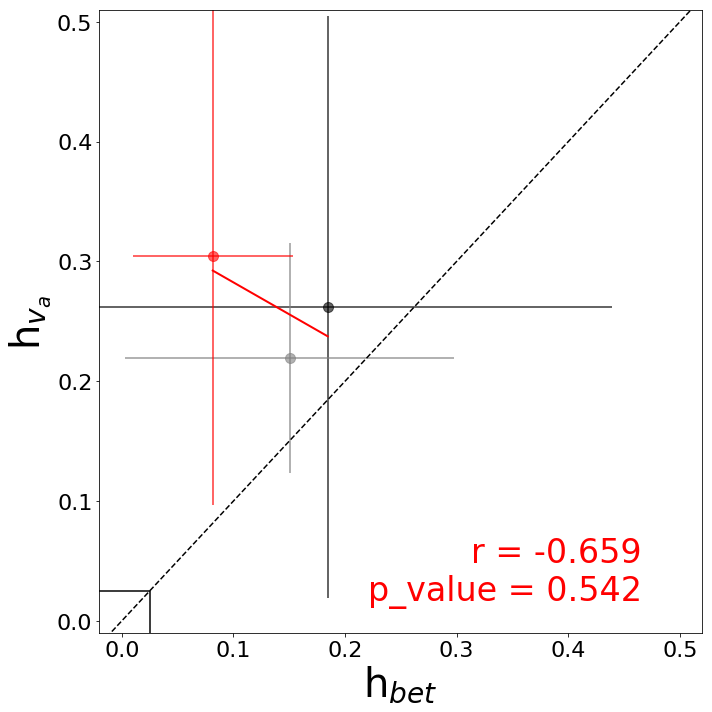

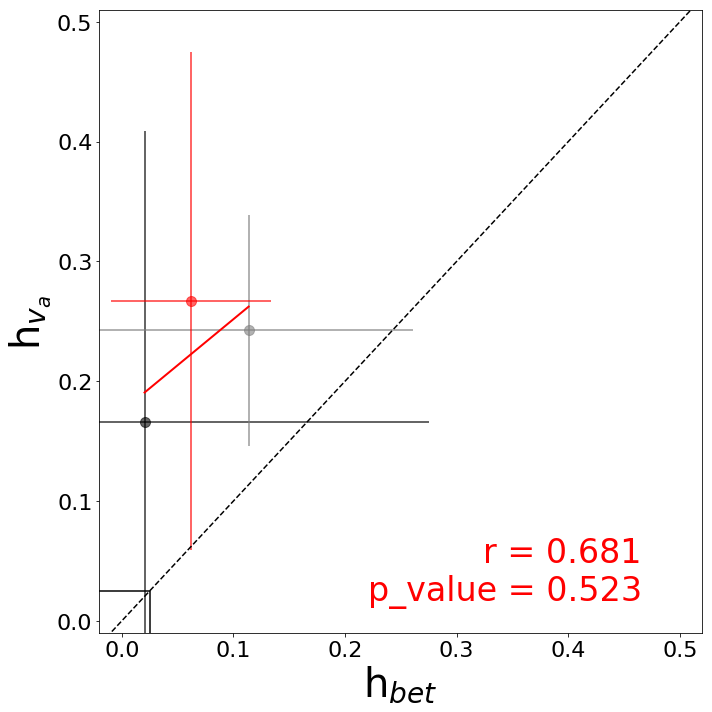

In [15]:
print('Moyenne par block')
fig, axs = scatter_mean(h_bet_block, h_va_block, '', maxx=0.5, maxy=0.5, color=c)
fig, axs = scatter_mean(h_bet_block, h_va_block, '', maxx=0.5, maxy=0.5, mean='mediane', color=c)

#fig1, axs1 = scatter_mean(h_bet_block, h_va_block, '', maxx=0.1, maxy=0.1, ellipse=True)

Moyenne par Sujet block log


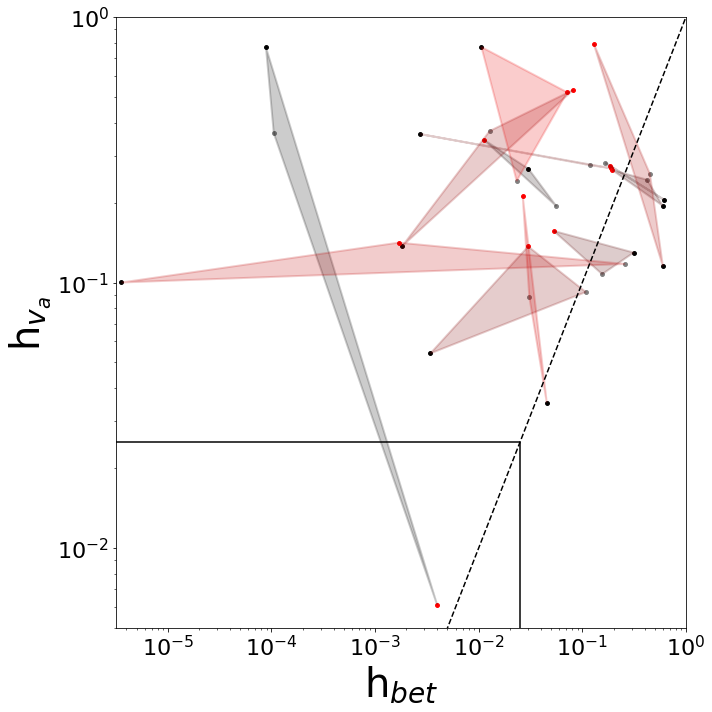

In [16]:
print('Moyenne par Sujet block log')

fig, ax = scatter_mean(h_bet['block'], h_va['block'], '', triangle=True, maxx=0.8, maxy=0.8, ex=0.02, ey=0.01,
                       supp=True, color=COLOR, log=True, line_r=False)

Moyenne par Sujet block


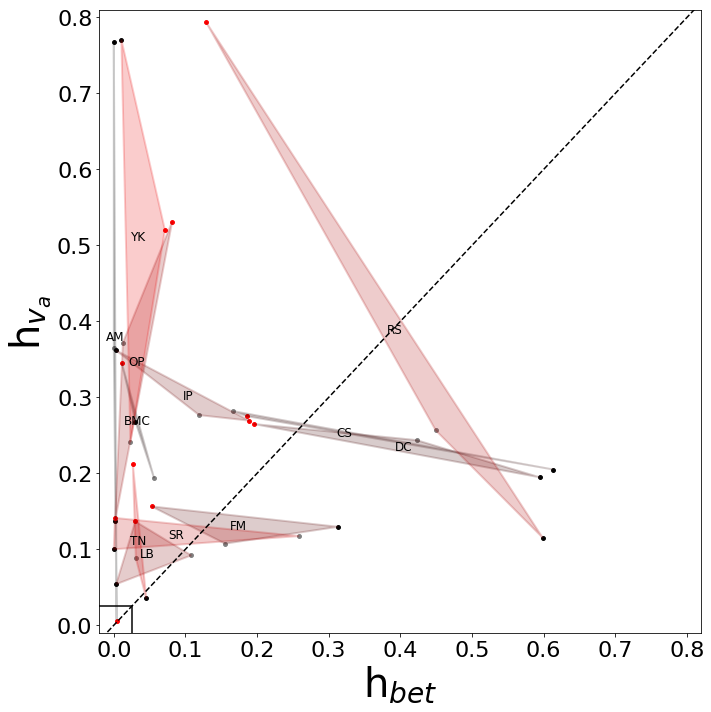

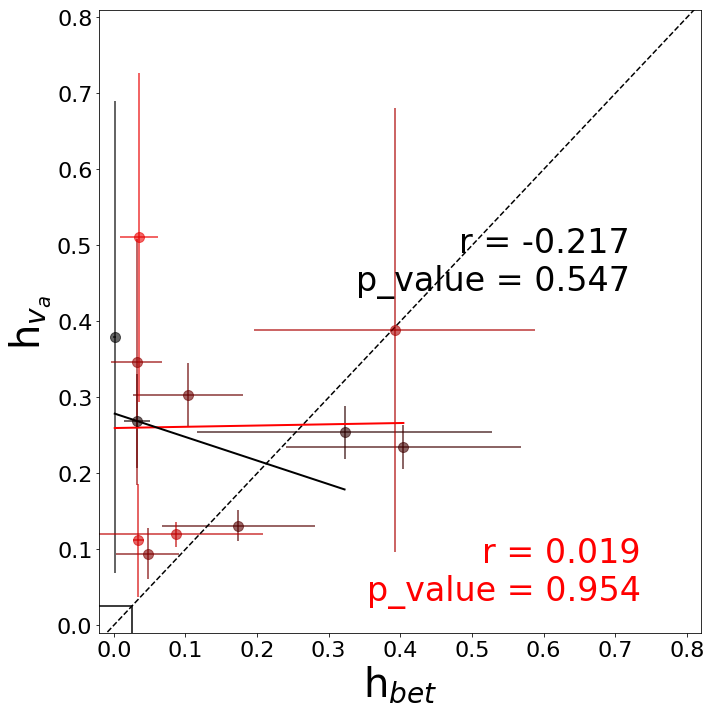

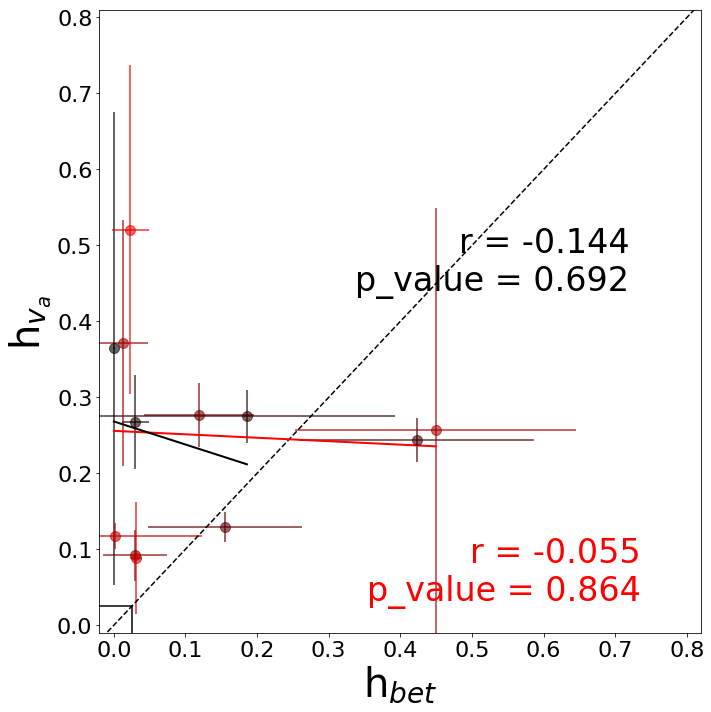

In [17]:
print('Moyenne par Sujet block')

fig, ax = scatter_mean(h_bet['block'], h_va['block'], '', triangle=True, maxx=0.8, maxy=0.8, ex=0.02, ey=0.01,
                       supp=True, color=COLOR, log=False, line_r=False)
fig, ax = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.8, maxy=0.8, supp=True, color=COLOR)

fig, ax = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.8, maxy=0.8, mean='mediane', supp=True, color=COLOR)
##fig1, axs1 = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.4, maxy=0.1, ellipse=True)

Moyenne par Sujet pause


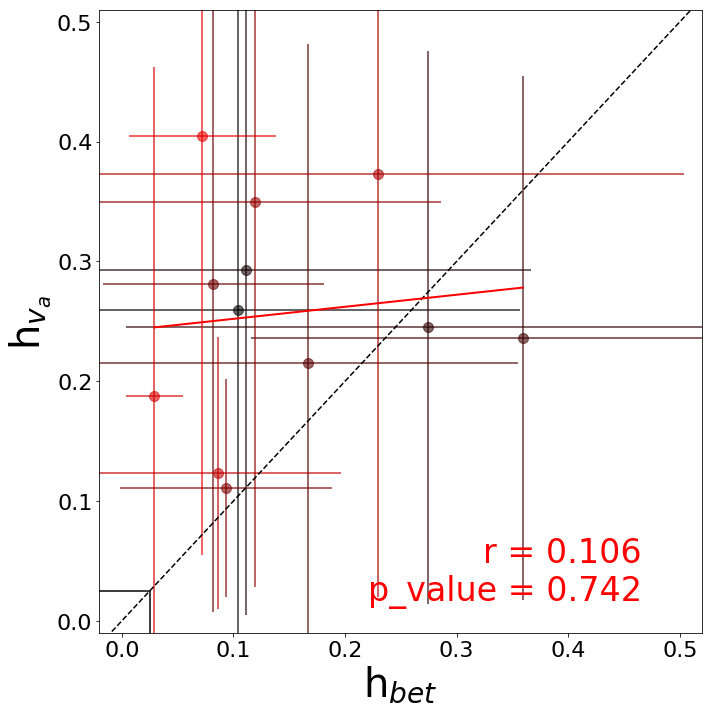

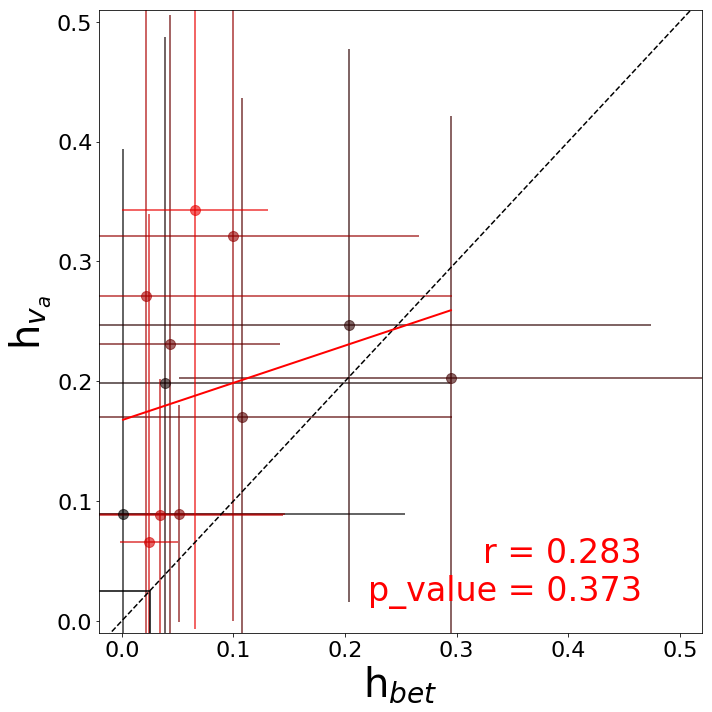

In [18]:
print('Moyenne par Sujet pause')
fig, axs = scatter_mean(h_bet['pause'], h_va['pause'], '', maxx=0.5, maxy=0.5, color=COLOR)
fig, axs = scatter_mean(h_bet['pause'], h_va['pause'], '', maxx=0.5, maxy=0.5, mean='mediane', color=COLOR)
##fig1, axs1 = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.4, maxy=0.4, ellipse=True)

## MI